# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
from dataclasses import dataclass
from os.path import exists
import random
from typing import Tuple, List, Dict, Optional, Union

import numpy
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
SEED = 7
numpy.random.seed(SEED)
random.seed(SEED)

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [3]:
def read_csv_dataset(
        path_to_csv: str, shuffle: bool = True, converters: Dict = None
) -> numpy.array:
    if not exists(path_to_csv):
        raise ValueError(f"Can't find cancer dataset here: {path_to_csv}")
    data = numpy.loadtxt(
        path_to_csv, delimiter=",", skiprows=1, converters=converters, encoding="utf_8"
    )
    if shuffle:
        numpy.random.shuffle(data)
    return data

def read_cancer_dataset(path_to_csv: str) -> Tuple[numpy.array, numpy.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : numpy.array
        Матрица признаков опухолей.
    y : numpy.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).
    """
    data = read_csv_dataset(path_to_csv, True, {0: lambda _l: _l == 'M'})
    _X, _y = data[:, 1:], data[:, 0]
    return _X, _y.astype(numpy.short)

def read_spam_dataset(path_to_csv: str) -> Tuple[numpy.array, numpy.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : numpy.array
        Матрица признаков сообщений.
    y : numpy.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    data = read_csv_dataset(path_to_csv, True)
    _X, _y = data[:, :-1], data[:, -1]
    return _X, _y.astype(numpy.short)

In [4]:
read_cancer_dataset("cancer.csv")

(array([[1.166e+01, 1.707e+01, 7.370e+01, ..., 4.262e-02, 2.731e-01,
         6.825e-02],
        [1.553e+01, 3.356e+01, 1.037e+02, ..., 2.014e-01, 3.512e-01,
         1.204e-01],
        [1.193e+01, 2.153e+01, 7.653e+01, ..., 7.247e-02, 2.438e-01,
         8.541e-02],
        ...,
        [1.169e+01, 2.444e+01, 7.637e+01, ..., 1.308e-01, 2.803e-01,
         9.970e-02],
        [1.377e+01, 2.229e+01, 9.063e+01, ..., 1.673e-01, 3.080e-01,
         9.333e-02],
        [8.671e+00, 1.445e+01, 5.442e+01, ..., 0.000e+00, 2.592e-01,
         7.848e-02]]),
 array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
 

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [5]:
def train_test_split(x_full: numpy.array, y_full: numpy.array, ratio: float
                     ) -> Tuple[numpy.array, numpy.array, numpy.array, numpy.array]:
    """

    Parameters
    ----------
    x_full : numpy.array
        Матрица признаков.
    y_full : numpy.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : numpy.array
        Матрица признаков для train выборки.
    y_train : numpy.array
        Вектор меток для train выборки.
    X_test : numpy.array
        Матрица признаков для test выборки.
    y_test : numpy.array
        Вектор меток для test выборки.

    """
    assert x_full.shape[0] == y_full.shape[0]
    train_last_index = int(x_full.shape[0] * ratio)
    _X_train, _y_train = x_full[:train_last_index, :], y_full[:train_last_index]
    _X_test, _y_test = x_full[train_last_index:, :], y_full[train_last_index:]
    return _X_train, _y_train, _X_test, _y_test

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [6]:
def get_precision_recall_accuracy(y_pred: numpy.array, y_true: numpy.array
                                  ) -> Tuple[numpy.array, numpy.array, float]:
    """

    Parameters
    ----------
    y_pred : numpy.array
        Вектор классов, предсказанных моделью.
    y_true : numpy.array
        Вектор истинных классов.

    Returns
    -------
    precision : numpy.array
        Вектор с precision для каждого класса.
    recall : numpy.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    n_classes = max(y_true.max(), y_pred.max()) + 1 # Assume classes numerates from zero
    confusion_matrix = numpy.zeros((n_classes, n_classes), dtype=numpy.short)
    numpy.add.at(confusion_matrix, (y_pred, y_true), 1) # row for predicted value, column for true
    class_range = numpy.arange(n_classes)
    precision = confusion_matrix[class_range, class_range] / confusion_matrix.sum(axis=1)
    recall = confusion_matrix[class_range, class_range] / confusion_matrix.sum(axis=0)
    accuracy = confusion_matrix.trace() / confusion_matrix.sum()
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [7]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(numpy.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(numpy.min(ys)-0.01, numpy.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [8]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in numpy.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [9]:
class KDTree:

    @dataclass
    class _KDTreeNode:
        is_leaf: bool
        split_feature: Optional[int] = None
        median_value: Optional[float] = None
        left_child: Optional["KDTree._KDTreeNode"] = None   # x[split_feature] <= median_value
        right_child: Optional["KDTree._KDTreeNode"] = None  # x[split_feature] > median_value

    @dataclass
    class _RequestPointsResult:
        def __init__(self, points: numpy.array, k: int):
            self.points = points
            self.k = k
            self.k_closest = numpy.full((points.shape[0], k), -1, dtype=numpy.short)
            self.k_distances = numpy.full((points.shape[0], k), -1, dtype=numpy.float)

    def __init__(self, points: numpy.array, leaf_size: int = 40):
        """
        Parameters
        ----------
        points : numpy.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области, 
            в которых не меньше leaf_size точек).
        """
        self._points = points.copy()
        self._n_points, self._n_features = self._points.shape
        self._leaf_size = leaf_size
        self._root = self._build_kd_tree(self._points, 0)

    def query(self, points: numpy.array, k: int = 1, return_distances: bool = False) -> Union[List[List], Tuple]:
        """
        Parameters
        ----------
        points : numpy.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.
        return_distances : bool
            Возвращать или нет сами расстояния

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k): 
            индексы k ближайших соседей для всех точек из X.
        """
        if points.shape[1] != self._n_features:
            raise ValueError(f"Query points have unsatisfied number of features:"
                             f"expected {self._n_features}, actual {points.shape[1]}")
        result = self._RequestPointsResult(points, k)
        self.get_k_neighbours(
            numpy.arange(self._n_points),
            numpy.arange(result.points.shape[0]),
            result,
            self._root
        )
        if return_distances:
            return result.k_closest, result.k_distances
        return result.k_closest

    @staticmethod
    def _get_split_feature(depth: int, points: numpy.array, strategy: str):
        if strategy == "cycle":
            return depth % points.shape[1]
        elif strategy == "max_variance":
            feature_stds = numpy.std(points, axis=0)
            return numpy.argmax(feature_stds)
        elif strategy == "equal_parts":
            feature_medians = numpy.median(points, axis=0)
            less_equal_mask = points <= feature_medians
            shifted_ratios = numpy.abs(less_equal_mask.sum(axis=0) / points.shape[0] - 0.5)
            return numpy.argmin(shifted_ratios)
        else:
            raise ValueError("Unknown strategy")

    def _build_kd_tree(self, points: numpy.array, depth: int) -> _KDTreeNode:
        if points.shape[0] <= self._leaf_size:
            return self._KDTreeNode(is_leaf=True)

        split_feature = self._get_split_feature(depth, points, "max_variance")
        median_value = numpy.median(points[:, split_feature])
        less_equal_mask = points[:, split_feature] <= median_value
        child_size = less_equal_mask.sum()
        if child_size == 0 or child_size == points.shape[0]:
            return self._KDTreeNode(is_leaf=True)
        left_child = self._build_kd_tree(points[less_equal_mask], depth + 1)
        right_child = self._build_kd_tree(points[numpy.logical_not(less_equal_mask)], depth + 1)
        return self._KDTreeNode(False, split_feature, median_value, left_child, right_child)

    def get_local_k_neighbours(
            self,
            idx_orig_points: numpy.array,
            idx_req_points: numpy.array,
            result: "KDTree._RequestPointsResult"
    ):
        if idx_req_points.shape[0] == 0:
            return
        n_points = idx_orig_points.shape[0]
        _r_points = numpy.repeat(result.points[idx_req_points, numpy.newaxis, :], n_points, axis=1)
        pairwise_distances = numpy.linalg.norm(_r_points - self._points[idx_orig_points], axis=2)

        k_safe = min(result.k, n_points)
        k_closest = pairwise_distances.argsort(axis=1)[:, :k_safe]
        pd_range = numpy.arange(pairwise_distances.shape[0])
        k_range = numpy.repeat(pd_range, k_safe).reshape(-1, k_safe)
        result.k_closest[idx_req_points, :k_safe] = idx_orig_points[k_closest]
        result.k_distances[idx_req_points, :k_safe] = pairwise_distances[k_range, k_closest]

    def get_k_neighbours(
            self,
            idx_orig_points: numpy.array,
            idx_req_points: numpy.array,
            result: "KDTree._RequestPointsResult",
            node: "KDTree._KDTreeNode",
    ):
        if idx_req_points.shape[0] == 0:
            return
        if node.is_leaf:
            self.get_local_k_neighbours(idx_orig_points, idx_req_points, result)
            return

        original_points_mask = self._points[idx_orig_points, node.split_feature] <= node.median_value
        request_points_mask = result.points[idx_req_points, node.split_feature] <= node.median_value

        self.get_k_neighbours(
            idx_orig_points[original_points_mask],
            idx_req_points[request_points_mask],
            result,
            node.left_child,
        )
        self.get_k_neighbours(
            idx_orig_points[numpy.logical_not(original_points_mask)],
            idx_req_points[numpy.logical_not(request_points_mask)],
            result,
            node.right_child,
        )

        dist_to_border = numpy.abs(
            result.points[idx_req_points, node.split_feature] - node.median_value
        )
        need_to_update = numpy.logical_or(
            result.k_distances[idx_req_points, -1] == -1,
            result.k_distances[idx_req_points, -1] > dist_to_border
        )
        self.get_local_k_neighbours(
            idx_orig_points,
            idx_req_points[need_to_update],
            result
        )

Поскольку данная структура данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [10]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, numpy.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = numpy.random.randn(100, 3)
X_test = numpy.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if numpy.sum(numpy.abs(numpy.array(numpy.array(predicted).shape) - numpy.array(numpy.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [11]:
class KNearest:
    _KDTree: Optional[KDTree] = None
    _labels: Optional[numpy.array] = None
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """
        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.
        """
        self._n_neighbours = n_neighbors
        self._leaf_size = leaf_size
    
    def fit(self, x: numpy.array, y: numpy.array):
        """
        Parameters
        ----------
        x : numpy.array
            Набор точек, по которым строится классификатор.
        y : numpy.array
            Метки точек, по которым строится классификатор.
        """        
        self._KDTree = KDTree(x, self._leaf_size)
        self._labels = y
        
    def predict_proba(self, x: numpy.array) -> List[numpy.array]:
        """
        Parameters
        ----------
        x : numpy.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[numpy.array]
            Список numpy.array (длина каждого numpy.array равна числу классов):
            вероятности классов для каждой точки X.
        """
        if self._KDTree is None:
            raise RuntimeError(f"fit classifier before predicting")
        k_closest = self._KDTree.query(x, self._n_neighbours)
        n_classes = int(self._labels.max() + 1)
        probabilities = numpy.zeros((x.shape[0], n_classes), dtype=numpy.short)
        iter_range = numpy.repeat(numpy.arange(x.shape[0]), self._n_neighbours)
        iter_class = self._labels[k_closest].reshape(-1)
        numpy.add.at(probabilities, (iter_range, iter_class), 1)
        return probabilities / probabilities.sum(axis=1).reshape(-1, 1)

    def predict(self, x: numpy.array) -> numpy.array:
        """
        Parameters
        ----------
        x : numpy.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        numpy.array
            Вектор предсказанных классов.
        """
        return numpy.argmax(self.predict_proba(x), axis=1)


In [12]:
class StandardScaler:
    _mean: Optional[float] = None
    _std: Optional[float] = None

    def fit(self, x: numpy.array):
        self._mean = x.mean(axis=0)
        self._std = x.std(axis=0)

    def transform(self, x: numpy.array) -> numpy.array:
        if self._mean is None or self._std is None:
            raise RuntimeError(f"Fit scaler before transforming")
        return (x - self._mean) / self._std

    def fit_transform(self, x: numpy.array) -> numpy.array:
        self.fit(x)
        return self.transform(x)


class MinMaxScaler:
    _min: Optional[float] = None
    _max: Optional[float] = None

    def fit(self, x: numpy.array):
        self._min = x.min(axis=0)
        self._max = x.max(axis=0)

    def transform(self, x: numpy.array) -> numpy.array:
        if self._min is None or self._max is None:
            raise RuntimeError(f"Fit scaler before transforming")
        return (x - self._min) / (self._max - self._min)

    def fit_transform(self, x: numpy.array) -> numpy.array:
        self.fit(x)
        return self.transform(x)


class MaxAbsScaler:
    _max_abs: Optional[float] = None

    def fit(self, x: numpy.array):
        self._max_abs = numpy.abs(x).max()

    def transform(self, x: numpy.array) -> numpy.array:
        if self._max_abs is None:
            raise RuntimeError(f"Fit scaler before transforming")
        return x / self._max_abs

    def fit_transform(self, x: numpy.array) -> numpy.array:
        self.fit(x)
        return self.transform(x)

Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

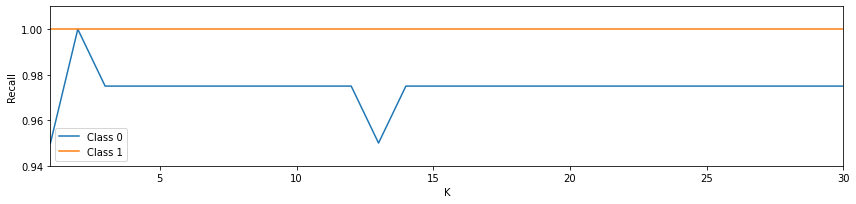

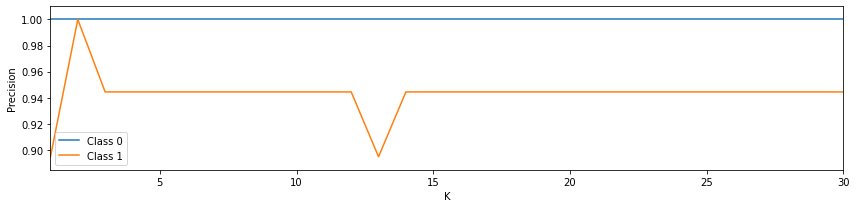

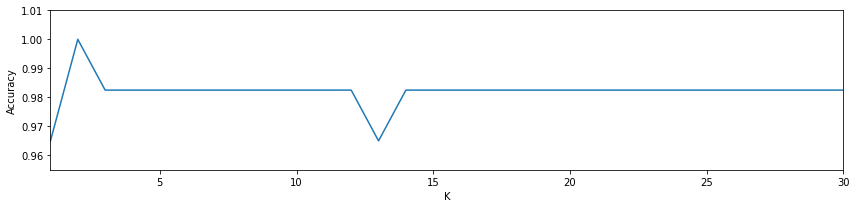

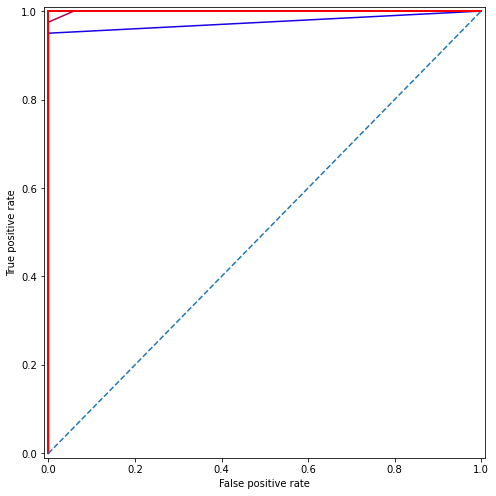

CPU times: user 2.19 s, sys: 502 ms, total: 2.69 s
Wall time: 1.88 s


In [13]:
%%time
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

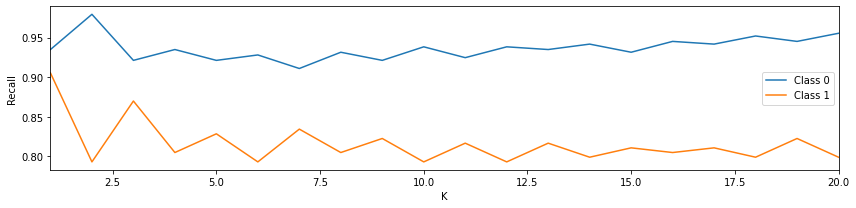

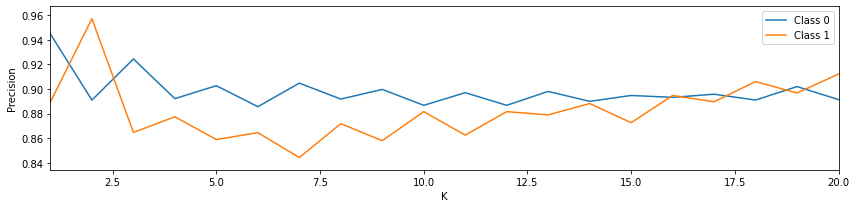

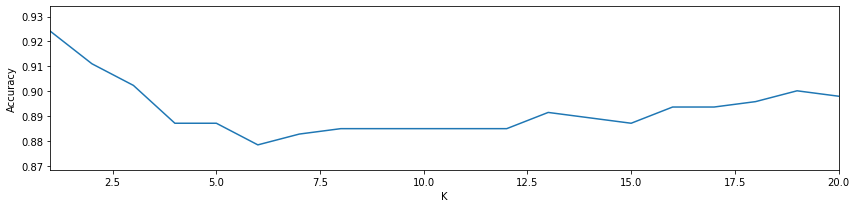

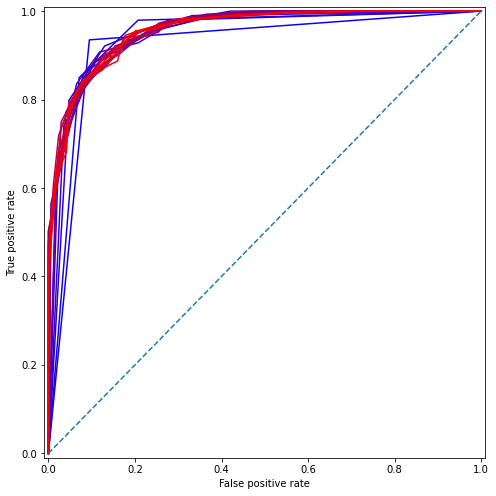

CPU times: user 1min 1s, sys: 29.3 s, total: 1min 30s
Wall time: 1min 30s


In [14]:
%%time
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)